# Push Bayesian Deep Learning Tutorial

## Introduction

In this notebook, we introduce Bayesian Deep Learning (BDL) and demonstrate how to use Push to perform BDL by running a deep ensemble.

## Background: The Posterior Predictive Distribution

The goal of BDL methods is to compute the *posterior predictive distribution*
$$
p(y|x, \mathcal{D}) = \int p(y|x, \theta) p(\theta | \mathcal{D}) \, d\theta
$$
where $y$ is an output, $x$ is an input, $\theta$ are parameters, and $\mathcal{D} = (x_i, y_i)_{i}$ is a dataset. In general, this integral is intractable and must be approximated.

### Monte Carlo Approximation

We can approximate the posterior predictive distribution with a Monte Carlo approximation [1]: 
$$
p(y|x, \mathcal{D}) \approx \frac{1}{J} \sum_{j=1}^{J} p(y|x, \theta_j), \quad \theta_j \sim p(\theta | D)
$$
where each $\theta_j$ corresponds to a unique parameter setting.

### Deep Ensembles

 *Deep ensembles* train $J$ different initializations of the same neural network (NN). If we average $p(y | x, \theta_j)$ over $J$ parameter settings $\theta_j$, we are essentially performing a Monte Carlo estimate that approximates the posterior predictive distribution. Thus, deep ensembles form a simple BDL method.

## Deep Ensembles in Push

We will now introduce deep ensembles in Push. Push interoperates with PyTorch, and so all datasets and models can use PyTorch components. Push also has concurrent execution semantics.

### Dataset

For illustrative purposes, we create a random dataset with $N$ points of dimension $D$.

In [1]:
from bdl import RandDataset
from bdl import SineDataset

D = 1
batch_size = 128
N = 1
dataset = SineDataset(batch_size, N, D)

```py
class RandDataset(Dataset):
    def __init__(self, batch_size, N, D):
        self.xs = torch.randn(batch_size*N, D)
        self.ys = torch.randn(batch_size*N, 1)

    def __len__(self):
        return len(self.xs)

    def __getitem__(self, idx):
        return self.xs[idx], self.ys[idx]


class SineDataset(Dataset):
    def __init__(self, batch_size, N, D):
        self.xs = torch.linspace(0, 2 * 3.1416, batch_size * N * D).reshape(batch_size * N, D)
        self.ys = torch.sin(self.xs[:, 0]).reshape(-1, 1)

    def __len__(self):
        return len(self.xs)

    def __getitem__(self, idx):
        return self.xs[idx], self.ys[idx]

```

## Plotting the Dataset 

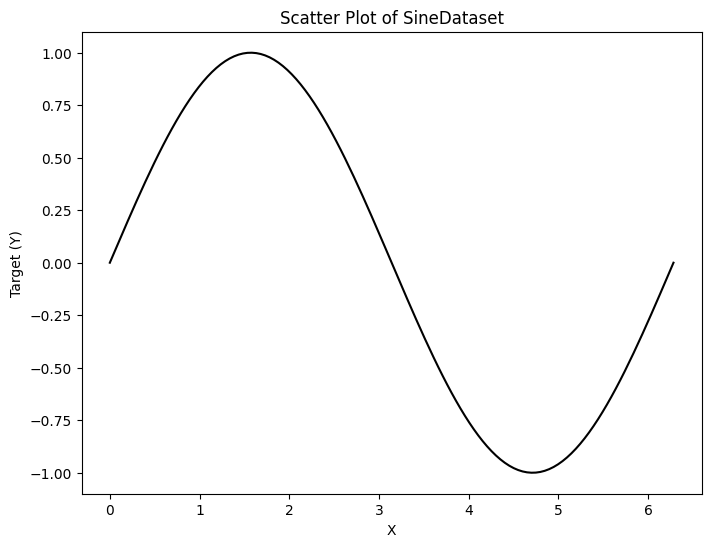

In [2]:
import matplotlib.pyplot as plt
# Extract the data
xs = dataset.xs
ys = dataset.ys

# Plot the data without a colorbar
plt.figure(figsize=(8, 6))
plt.plot(xs, ys, c ="black")
plt.title('Scatter Plot of SineDataset')
plt.xlabel('X')
plt.ylabel('Target (Y)')
plt.show()

### Neural Network

We create a simple neural network (NN). This NN contains two fully-connected layers of dimension $D$ and uses a ReLU activation function. 

In [3]:
from bdl import MiniNN
from bdl import BiggerNN

```py
class BiggerNN(nn.Module):
    def __init__(self, n, input_dim, output_dim, hidden_dim):
        super(BiggerNN, self).__init__()
        self.minis = []
        self.n = n
       
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        for i in range(0, n):
            self.minis += [MiniNN(hidden_dim)]
            self.add_module("mini_layer"+str(i), self.minis[-1])
        self.fc = nn.Linear(hidden_dim, output_dim)
            
    def forward(self, x):
        x = self.input_layer(x)
        for i in range(0, self.n):
            x = self.minis[i](x)
        return self.fc(x)

class MiniNN(nn.Module):
    def __init__(self, D):
        super(MiniNN, self).__init__()
        self.fc1 = nn.Linear(D, D)
        self.fc2 = nn.Linear(D, D)

    def forward(self, x):
        x = self.fc1(x)
        x = torch.nn.ReLU()(x)
        x = self.fc2(x)
        return x
    
```

### Training a Standard Neural Network (num_ensemble = 1)


In [5]:
import torch
from torch.utils.data import DataLoader
import push.bayes.ensemble

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

epochs = 100
num_ensembles = 1
n = 1
input_dim = 1
output_dim = 1
hidden_dim = 4
standard_params = push.bayes.ensemble.train_deep_ensemble(
    dataloader,
    torch.nn.MSELoss(),
    epochs,
    BiggerNN, n, input_dim, output_dim, hidden_dim,
    num_devices=1,
    num_ensembles=num_ensembles
)


  0%|          | 0/100 [00:00<?, ?it/s]

Average loss 0 tensor(0.5176)
Average loss 0 tensor(1.3312)
Average loss 0 tensor(0.6914)
Average loss 0 tensor(0.9597)
Average loss 0 tensor(0.5207)
Average loss 0 tensor(0.3786)
Average loss 0 tensor(0.4217)
Average loss 0 tensor(0.4779)
Average loss 0 tensor(0.4949)
Average loss 0 tensor(0.4788)
Average loss 0 tensor(0.4508)
Average loss 0 tensor(0.4264)
Average loss 0 tensor(0.4058)
Average loss 0 tensor(0.3765)
Average loss 0 tensor(0.3302)
Average loss 0 tensor(0.2728)
Average loss 0 tensor(0.2223)
Average loss 0 tensor(0.2015)
Average loss 0 tensor(0.2095)
Average loss 0 tensor(0.2223)
Average loss 0 tensor(0.2333)
Average loss 0 tensor(0.2157)
Average loss 0 tensor(0.1828)
Average loss 0 tensor(0.1676)
Average loss 0 tensor(0.1739)
Average loss 0 tensor(0.1886)
Average loss 0 tensor(0.2003)
Average loss 0 tensor(0.2032)
Average loss 0 tensor(0.1968)
Average loss 0 tensor(0.1841)
Average loss 0 tensor(0.1700)
Average loss 0 tensor(0.1594)
Average loss 0 tensor(0.1550)
Average lo

 19%|█▉        | 19/100 [00:00<00:01, 47.80it/s]

Average loss 0 tensor(0.1613)
Average loss 0 tensor(0.1638)
Average loss 0 tensor(0.1612)
Average loss 0 tensor(0.1558)
Average loss 0 tensor(0.1521)
Average loss 0 tensor(0.1521)
Average loss 0 tensor(0.1541)
Average loss 0 tensor(0.1558)
Average loss 0 tensor(0.1559)
Average loss 0 tensor(0.1544)
Average loss 0 tensor(0.1519)
Average loss 0 tensor(0.1498)
Average loss 0 tensor(0.1486)
Average loss 0 tensor(0.1485)
Average loss 0 tensor(0.1486)
Average loss 0 tensor(0.1479)
Average loss 0 tensor(0.1463)
Average loss 0 tensor(0.1444)
Average loss 0 tensor(0.1428)
Average loss 0 tensor(0.1423)
Average loss 0 tensor(0.1426)
Average loss 0 tensor(0.1429)
Average loss 0 tensor(0.1423)
Average loss 0 tensor(0.1407)
Average loss 0 tensor(0.1386)
Average loss 0 tensor(0.1369)
Average loss 0 tensor(0.1357)
Average loss 0 tensor(0.1347)
Average loss 0 tensor(0.1332)
Average loss 0 tensor(0.1311)


 50%|█████     | 50/100 [00:00<00:00, 97.30it/s]

Average loss 0 tensor(0.1287)
Average loss 0 tensor(0.1266)
Average loss 0 tensor(0.1249)
Average loss 0 tensor(0.1232)
Average loss 0 tensor(0.1210)
Average loss 0 tensor(0.1182)
Average loss 0 tensor(0.1156)
Average loss 0 tensor(0.1133)
Average loss 0 tensor(0.1110)
Average loss 0 tensor(0.1084)
Average loss 0 tensor(0.1055)
Average loss 0 tensor(0.1030)
Average loss 0 tensor(0.1007)
Average loss 0 tensor(0.0981)
Average loss 0 tensor(0.0953)
Average loss 0 tensor(0.0928)
Average loss 0 tensor(0.0906)
Average loss 0 tensor(0.0883)
Average loss 0 tensor(0.0859)
Average loss 0 tensor(0.0839)
Average loss 0 tensor(0.0821)
Average loss 0 tensor(0.0801)
Average loss 0 tensor(0.0782)
Average loss 0 tensor(0.0766)
Average loss 0 tensor(0.0749)
Average loss 0 tensor(0.0732)
Average loss 0 tensor(0.0716)
Average loss 0 tensor(0.0701)
Average loss 0 tensor(0.0685)
Average loss 0 tensor(0.0671)
Average loss 0 tensor(0.0657)


 81%|████████  | 81/100 [00:00<00:00, 123.63it/s]

Average loss 0 tensor(0.0642)
Average loss 0 tensor(0.0629)
Average loss 0 tensor(0.0617)
Average loss 0 tensor(0.0604)
Average loss 0 tensor(0.0594)


100%|██████████| 100/100 [00:01<00:00, 95.20it/s]


In the previous cell, we saved the output of our train_deep_ensemble function inside standard_params. train_deep_ensemble returns a list of all the parameters for each deep ensemble trained. Below we can see what these parameters look like. Since we are only training one model, the list will contain only one parameter setting.

In [8]:
standard_params = standard_params[0]
standard_params[0]

tensor([[-0.1363],
        [-0.5134],
        [-0.5130],
        [ 0.0195]])

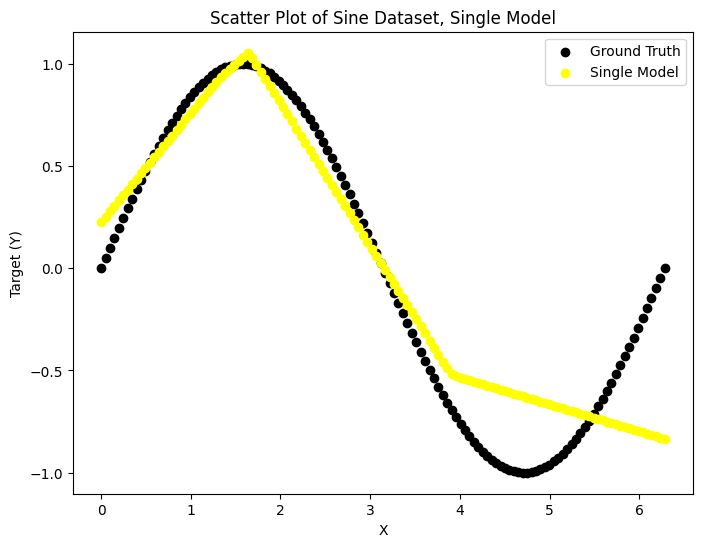

In [30]:
model = BiggerNN(n, input_dim, output_dim, hidden_dim)
    
# Check if the number of parameters in the list matches the number of model parameters
if len(standard_params) != len(list(model.parameters())):
    print("The number of parameters in the list does not match the number of model parameters.")
else:
    # Iterate through the model parameters and assign values from the list
    for model_param, param_value in zip(model.parameters(), standard_params):
        model_param.data = param_value


model_outputs = []
for xs in dataset.xs:
    model_outputs.append(model(xs).detach())


# Extract the data
xs = dataset.xs
ys = dataset.ys

# Plot the data without a colorbar
plt.figure(figsize=(8, 6))
plt.scatter(xs, ys, c="black", label= "Ground Truth")
plt.scatter(xs, model_outputs, c="yellow", label="Single Model")
plt.title('Scatter Plot of Sine Dataset, Single Model')
plt.xlabel('X')
plt.ylabel('Target (Y)')
plt.legend()
plt.show()


### Training a Deep Ensembles (num_ensemble = 2, 4, 8)

In [21]:
import torch
from torch.utils.data import DataLoader
import push.bayes.ensemble

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

epochs = 100
num_ensembles = 2
n = 1
input_dim = 1
output_dim = 1
hidden_dim = 4
two_particle_params = push.bayes.ensemble.train_deep_ensemble(
    dataloader,
    torch.nn.MSELoss(),
    epochs,
    BiggerNN, n, input_dim, output_dim, hidden_dim,
    num_devices=1,
    num_ensembles=num_ensembles
)

num_ensembles = 4
four_particle_params = push.bayes.ensemble.train_deep_ensemble(
    dataloader,
    torch.nn.MSELoss(),
    epochs,
    BiggerNN, n, input_dim, output_dim, hidden_dim,
    num_devices=1,
    num_ensembles=num_ensembles
)

num_ensembles = 8
eight_particle_params = push.bayes.ensemble.train_deep_ensemble(
    dataloader,
    torch.nn.MSELoss(),
    epochs,
    BiggerNN, n, input_dim, output_dim, hidden_dim,
    num_devices=1,
    num_ensembles=num_ensembles
)


  0%|          | 0/100 [00:00<?, ?it/s]

Average loss 0 tensor(0.3777)
Average loss 0 tensor(3.6472)
Average loss 0 tensor(0.4257)
Average loss 0 tensor(0.5000)
Average loss 0 tensor(0.7527)
Average loss 0 tensor(0.7638)
Average loss 0 tensor(0.6995)
Average loss 0 tensor(0.5864)
Average loss 0 tensor(0.4582)
Average loss 0 tensor(0.3503)
Average loss 0 tensor(0.3239)
Average loss 0 tensor(0.4108)
Average loss 0 tensor(0.4391)
Average loss 0 tensor(0.3435)
Average loss 0 tensor(0.2793)
Average loss 0 tensor(0.3098)
Average loss 0 tensor(0.3362)
Average loss 0 tensor(0.2967)
Average loss 0 tensor(0.2196)
Average loss 0 tensor(0.1977)
Average loss 0 tensor(0.2494)
Average loss 0 tensor(0.2157)


 12%|█▏        | 12/100 [00:00<00:02, 29.34it/s]

Average loss 0 tensor(0.1651)
Average loss 0 tensor(0.1872)
Average loss 0 tensor(0.2151)
Average loss 0 tensor(0.1959)
Average loss 0 tensor(0.1606)
Average loss 0 tensor(0.1714)
Average loss 0 tensor(0.1912)
Average loss 0 tensor(0.1596)
Average loss 0 tensor(0.1437)
Average loss 0 tensor(0.1580)
Average loss 0 tensor(0.1563)
Average loss 0 tensor(0.1354)
Average loss 0 tensor(0.1304)
Average loss 0 tensor(0.1439)
Average loss 0 tensor(0.1384)
Average loss 0 tensor(0.1250)
Average loss 0 tensor(0.1293)
Average loss 0 tensor(0.1348)
Average loss 0 tensor(0.1251)


 33%|███▎      | 33/100 [00:00<00:01, 62.03it/s]

Average loss 0 tensor(0.1169)
Average loss 0 tensor(0.1229)
Average loss 0 tensor(0.1211)
Average loss 0 tensor(0.1132)
Average loss 0 tensor(0.1157)
Average loss 0 tensor(0.1128)
Average loss 0 tensor(0.1055)
Average loss 0 tensor(0.1069)
Average loss 0 tensor(0.1013)
Average loss 0 tensor(0.0932)
Average loss 0 tensor(0.0929)
Average loss 0 tensor(0.0831)
Average loss 0 tensor(0.0804)
Average loss 0 tensor(0.0739)
Average loss 0 tensor(0.0681)
Average loss 0 tensor(0.0626)
Average loss 0 tensor(0.0571)
Average loss 0 tensor(0.0510)
Average loss 0 tensor(0.0471)
Average loss 0 tensor(0.0384)


 53%|█████▎    | 53/100 [00:00<00:00, 78.41it/s]

Average loss 0 tensor(0.0369)
Average loss 0 tensor(0.0309)
Average loss 0 tensor(0.0239)
Average loss 0 tensor(0.0214)
Average loss 0 tensor(0.0216)
Average loss 0 tensor(0.0265)
Average loss 0 tensor(0.0363)
Average loss 0 tensor(0.0757)
Average loss 0 tensor(0.0712)
Average loss 0 tensor(0.0573)
Average loss 0 tensor(0.0091)
Average loss 0 tensor(0.0405)
Average loss 0 tensor(0.0761)
Average loss 0 tensor(0.0099)
Average loss 0 tensor(0.0407)
Average loss 0 tensor(0.0617)
Average loss 0 tensor(0.0085)
Average loss 0 tensor(0.0631)
Average loss 0 tensor(0.0243)


 73%|███████▎  | 73/100 [00:01<00:00, 86.36it/s]

Average loss 0 tensor(0.0348)
Average loss 0 tensor(0.0306)
Average loss 0 tensor(0.0196)
Average loss 0 tensor(0.0323)
Average loss 0 tensor(0.0171)
Average loss 0 tensor(0.0308)
Average loss 0 tensor(0.0150)
Average loss 0 tensor(0.0268)
Average loss 0 tensor(0.0159)
Average loss 0 tensor(0.0239)
Average loss 0 tensor(0.0157)
Average loss 0 tensor(0.0207)
Average loss 0 tensor(0.0154)
Average loss 0 tensor(0.0186)
Average loss 0 tensor(0.0145)
Average loss 0 tensor(0.0165)
Average loss 0 tensor(0.0134)
Average loss 0 tensor(0.0151)
Average loss 0 tensor(0.0122)


100%|██████████| 100/100 [00:01<00:00, 68.89it/s]


Average loss 0 tensor(0.0137)


  0%|          | 0/100 [00:00<?, ?it/s]

Average loss 0 tensor(0.7233)
Average loss 0 tensor(0.6068)
Average loss 0 tensor(0.5110)
Average loss 0 tensor(0.4734)
Average loss 0 tensor(0.4162)
Average loss 0 tensor(0.3124)
Average loss 0 tensor(0.3431)
Average loss 0 tensor(0.2169)
Average loss 0 tensor(0.2770)
Average loss 0 tensor(0.2398)
Average loss 0 tensor(0.1931)
Average loss 0 tensor(0.2737)
Average loss 0 tensor(0.1930)


  8%|▊         | 8/100 [00:00<00:04, 19.05it/s]

Average loss 0 tensor(0.2199)
Average loss 0 tensor(0.2277)
Average loss 0 tensor(0.1808)
Average loss 0 tensor(0.1640)
Average loss 0 tensor(0.1840)
Average loss 0 tensor(0.1664)
Average loss 0 tensor(0.1640)
Average loss 0 tensor(0.1804)
Average loss 0 tensor(0.1751)
Average loss 0 tensor(0.1560)
Average loss 0 tensor(0.1572)


 20%|██        | 20/100 [00:00<00:02, 36.76it/s]

Average loss 0 tensor(0.1589)
Average loss 0 tensor(0.1441)
Average loss 0 tensor(0.1491)
Average loss 0 tensor(0.1571)
Average loss 0 tensor(0.1510)
Average loss 0 tensor(0.1491)
Average loss 0 tensor(0.1520)
Average loss 0 tensor(0.1440)
Average loss 0 tensor(0.1448)
Average loss 0 tensor(0.1465)
Average loss 0 tensor(0.1418)


 32%|███▏      | 32/100 [00:00<00:01, 45.59it/s]

Average loss 0 tensor(0.1442)
Average loss 0 tensor(0.1452)
Average loss 0 tensor(0.1413)
Average loss 0 tensor(0.1427)
Average loss 0 tensor(0.1411)
Average loss 0 tensor(0.1383)
Average loss 0 tensor(0.1419)
Average loss 0 tensor(0.1399)
Average loss 0 tensor(0.1389)
Average loss 0 tensor(0.1391)
Average loss 0 tensor(0.1350)


 44%|████▍     | 44/100 [00:01<00:01, 49.69it/s]

Average loss 0 tensor(0.1349)
Average loss 0 tensor(0.1302)
Average loss 0 tensor(0.1279)
Average loss 0 tensor(0.1247)
Average loss 0 tensor(0.1220)
Average loss 0 tensor(0.1158)
Average loss 0 tensor(0.1128)
Average loss 0 tensor(0.1058)
Average loss 0 tensor(0.0994)
Average loss 0 tensor(0.0940)
Average loss 0 tensor(0.0904)


 56%|█████▌    | 56/100 [00:01<00:00, 51.61it/s]

Average loss 0 tensor(0.0870)
Average loss 0 tensor(0.0820)
Average loss 0 tensor(0.0677)
Average loss 0 tensor(0.0537)
Average loss 0 tensor(0.0431)
Average loss 0 tensor(0.0347)
Average loss 0 tensor(0.0276)
Average loss 0 tensor(0.0218)
Average loss 0 tensor(0.0261)
Average loss 0 tensor(0.1996)
Average loss 0 tensor(0.3615)


 68%|██████▊   | 68/100 [00:01<00:00, 53.01it/s]

Average loss 0 tensor(0.1407)
Average loss 0 tensor(0.2636)
Average loss 0 tensor(0.2216)
Average loss 0 tensor(0.1986)
Average loss 0 tensor(0.1892)
Average loss 0 tensor(0.1582)
Average loss 0 tensor(0.1434)
Average loss 0 tensor(0.1323)
Average loss 0 tensor(0.1485)
Average loss 0 tensor(0.1863)
Average loss 0 tensor(0.1790)


 80%|████████  | 80/100 [00:01<00:00, 53.56it/s]

Average loss 0 tensor(0.1432)
Average loss 0 tensor(0.1279)
Average loss 0 tensor(0.1297)
Average loss 0 tensor(0.1306)
Average loss 0 tensor(0.1252)
Average loss 0 tensor(0.1089)
Average loss 0 tensor(0.0844)
Average loss 0 tensor(0.0671)
Average loss 0 tensor(0.0653)
Average loss 0 tensor(0.0680)
Average loss 0 tensor(0.0690)


 92%|█████████▏| 92/100 [00:02<00:00, 53.50it/s]

Average loss 0 tensor(0.0630)
Average loss 0 tensor(0.0560)
Average loss 0 tensor(0.0536)
Average loss 0 tensor(0.0547)
Average loss 0 tensor(0.0481)
Average loss 0 tensor(0.0393)
Average loss 0 tensor(0.0284)
Average loss 0 tensor(0.0261)
Average loss 0 tensor(0.0267)
Average loss 0 tensor(0.0199)


  0%|          | 0/100 [00:00<?, ?it/s]

Average loss 0 tensor(0.4070)
Average loss 0 tensor(1.4532)
Average loss 0 tensor(0.3581)
Average loss 0 tensor(1.1927)
Average loss 0 tensor(0.5378)


  4%|▍         | 4/100 [00:00<00:11,  8.09it/s]

Average loss 0 tensor(1.2963)
Average loss 0 tensor(0.5078)
Average loss 0 tensor(1.1261)
Average loss 0 tensor(0.4599)


  8%|▊         | 8/100 [00:00<00:07, 12.99it/s]

Average loss 0 tensor(0.8123)
Average loss 0 tensor(0.6443)
Average loss 0 tensor(0.5162)
Average loss 0 tensor(0.7127)


 12%|█▏        | 12/100 [00:01<00:05, 15.86it/s]

Average loss 0 tensor(0.3965)
Average loss 0 tensor(0.5984)
Average loss 0 tensor(0.3440)
Average loss 0 tensor(0.2313)


 16%|█▌        | 16/100 [00:01<00:04, 17.52it/s]

Average loss 0 tensor(1.6403)
Average loss 0 tensor(0.2773)
Average loss 0 tensor(1.5415)
Average loss 0 tensor(0.2479)


 20%|██        | 20/100 [00:01<00:04, 18.36it/s]

Average loss 0 tensor(1.8198)
Average loss 0 tensor(0.2480)
Average loss 0 tensor(1.7206)
Average loss 0 tensor(0.2479)


 24%|██▍       | 24/100 [00:01<00:04, 18.63it/s]

Average loss 0 tensor(1.8198)
Average loss 0 tensor(0.2480)
Average loss 0 tensor(1.7206)
Average loss 0 tensor(0.2479)


 28%|██▊       | 28/100 [00:01<00:03, 18.83it/s]

Average loss 0 tensor(1.8199)
Average loss 0 tensor(0.2480)
Average loss 0 tensor(1.7206)
Average loss 0 tensor(0.2479)


 32%|███▏      | 32/100 [00:02<00:03, 18.74it/s]

Average loss 0 tensor(1.8199)
Average loss 0 tensor(0.2480)
Average loss 0 tensor(1.7206)
Average loss 0 tensor(0.2479)


 36%|███▌      | 36/100 [00:02<00:03, 18.81it/s]

Average loss 0 tensor(1.8199)
Average loss 0 tensor(0.2480)
Average loss 0 tensor(1.7206)
Average loss 0 tensor(0.2479)


 40%|████      | 40/100 [00:02<00:03, 18.88it/s]

Average loss 0 tensor(1.8199)
Average loss 0 tensor(0.2480)
Average loss 0 tensor(1.7206)
Average loss 0 tensor(0.2479)


 44%|████▍     | 44/100 [00:02<00:02, 19.01it/s]

Average loss 0 tensor(1.8199)
Average loss 0 tensor(0.2480)
Average loss 0 tensor(1.7206)
Average loss 0 tensor(0.2479)


 48%|████▊     | 48/100 [00:02<00:02, 19.04it/s]

Average loss 0 tensor(1.8199)
Average loss 0 tensor(0.2480)
Average loss 0 tensor(1.7206)
Average loss 0 tensor(0.2479)


 52%|█████▏    | 52/100 [00:03<00:02, 19.07it/s]

Average loss 0 tensor(1.8199)
Average loss 0 tensor(0.2480)
Average loss 0 tensor(1.7206)
Average loss 0 tensor(0.2479)


 56%|█████▌    | 56/100 [00:03<00:02, 19.10it/s]

Average loss 0 tensor(1.8199)
Average loss 0 tensor(0.2480)
Average loss 0 tensor(1.7206)
Average loss 0 tensor(0.2479)


 60%|██████    | 60/100 [00:03<00:02, 19.08it/s]

Average loss 0 tensor(1.8200)
Average loss 0 tensor(0.2480)
Average loss 0 tensor(1.7206)
Average loss 0 tensor(0.2479)


 64%|██████▍   | 64/100 [00:03<00:01, 19.12it/s]

Average loss 0 tensor(1.8200)
Average loss 0 tensor(0.2480)
Average loss 0 tensor(1.7206)
Average loss 0 tensor(0.2479)


 68%|██████▊   | 68/100 [00:03<00:01, 19.08it/s]

Average loss 0 tensor(1.8200)
Average loss 0 tensor(0.2480)
Average loss 0 tensor(1.7206)
Average loss 0 tensor(0.2479)


 72%|███████▏  | 72/100 [00:04<00:01, 18.92it/s]

Average loss 0 tensor(1.8200)
Average loss 0 tensor(0.2480)
Average loss 0 tensor(1.7206)
Average loss 0 tensor(0.2479)


 76%|███████▌  | 76/100 [00:04<00:01, 19.05it/s]

Average loss 0 tensor(1.8200)
Average loss 0 tensor(0.2480)
Average loss 0 tensor(1.7206)
Average loss 0 tensor(0.2479)


 80%|████████  | 80/100 [00:04<00:01, 18.94it/s]

Average loss 0 tensor(1.8200)
Average loss 0 tensor(0.2480)
Average loss 0 tensor(1.7206)
Average loss 0 tensor(0.2479)


 84%|████████▍ | 84/100 [00:04<00:00, 19.03it/s]

Average loss 0 tensor(1.8200)
Average loss 0 tensor(0.2480)
Average loss 0 tensor(1.7206)
Average loss 0 tensor(0.2479)


 88%|████████▊ | 88/100 [00:05<00:00, 19.00it/s]

Average loss 0 tensor(1.8200)
Average loss 0 tensor(0.2480)
Average loss 0 tensor(1.7205)
Average loss 0 tensor(0.2479)


 92%|█████████▏| 92/100 [00:05<00:00, 18.98it/s]

Average loss 0 tensor(1.8200)
Average loss 0 tensor(0.2480)
Average loss 0 tensor(1.7205)
Average loss 0 tensor(0.2479)


 96%|█████████▌| 96/100 [00:05<00:00, 19.09it/s]

Average loss 0 tensor(1.8201)
Average loss 0 tensor(0.2480)
Average loss 0 tensor(1.7205)


100%|██████████| 100/100 [00:05<00:00, 17.75it/s]


The goal of deep ensembles is to get a better approximation of the posterior through averaging multiple runs of the same nueral network. Thus we must aggregate and average the predictions of each model to achieve this goal. First we initialize num_ensemble models with the parameters saved from training. We will save each model in the list, models.

In [25]:
two_particle_models = []
for i in range(len(two_particle_params)):
    model = BiggerNN(n, input_dim, output_dim, hidden_dim)
    
    # Check if the number of parameters in the list matches the number of model parameters
    if len(two_particle_params[i]) != len(list(model.parameters())):
        print("The number of parameters in the list does not match the number of model parameters.")
    else:
        # Iterate through the model parameters and assign values from the list
        for model_param, param_value in zip(model.parameters(), two_particle_params[i]):
            model_param.data = param_value

    two_particle_models.append(model)

four_particle_models = []
for i in range(len(four_particle_params)):
    model = BiggerNN(n, input_dim, output_dim, hidden_dim)
    
    # Check if the number of parameters in the list matches the number of model parameters
    if len(four_particle_params[i]) != len(list(model.parameters())):
        print("The number of parameters in the list does not match the number of model parameters.")
    else:
        # Iterate through the model parameters and assign values from the list
        for model_param, param_value in zip(model.parameters(), four_particle_params[i]):
            model_param.data = param_value

    four_particle_models.append(model)

eight_particle_models = []
for i in range(len(eight_particle_params)):
    model = BiggerNN(n, input_dim, output_dim, hidden_dim)
    
    # Check if the number of parameters in the list matches the number of model parameters
    if len(eight_particle_params[i]) != len(list(model.parameters())):
        print("The number of parameters in the list does not match the number of model parameters.")
    else:
        # Iterate through the model parameters and assign values from the list
        for model_param, param_value in zip(model.parameters(), eight_particle_params[i]):
            model_param.data = param_value

    eight_particle_models.append(model)

Then we loop through each model and save its output to a list of model_outputs. This is so that we can calculate an average over all model.

In [26]:
two_model_outputs = []
for i in range(len(two_particle_params)):
    model_i_output = []
    for xs in dataset.xs:
        model_i_output.append(two_particle_models[i](xs).detach())
    two_model_outputs.append(model_i_output)


four_model_outputs = []
for i in range(len(four_particle_params)):
    model_i_output = []
    for xs in dataset.xs:
        model_i_output.append(four_particle_models[i](xs).detach())
    four_model_outputs.append(model_i_output)


eight_model_outputs = []
for i in range(len(eight_particle_params)):
    model_i_output = []
    for xs in dataset.xs:
        model_i_output.append(eight_particle_models[i](xs).detach())
    eight_model_outputs.append(model_i_output)

Then we stack our output tensors and compute the average

In [27]:
transposed_lists = list(map(list, zip(*two_model_outputs)))

# Initialize an empty list to store the average tensors
two_model_averages = []

# Calculate the average for each list of tensors and add them to the 'averages' list
for tensors in transposed_lists:
    stacked_tensor = torch.stack(tensors)
    average_tensor = torch.mean(stacked_tensor, dim=0)
    two_model_averages.append(average_tensor)


transposed_lists = list(map(list, zip(*four_model_outputs)))

# Initialize an empty list to store the average tensors
four_model_averages = []

# Calculate the average for each list of tensors and add them to the 'averages' list
for tensors in transposed_lists:
    stacked_tensor = torch.stack(tensors)
    average_tensor = torch.mean(stacked_tensor, dim=0)
    four_model_averages.append(average_tensor)

transposed_lists = list(map(list, zip(*eight_model_outputs)))

# Initialize an empty list to store the average tensors
eight_model_averages = []

# Calculate the average for each list of tensors and add them to the 'averages' list
for tensors in transposed_lists:
    stacked_tensor = torch.stack(tensors)
    average_tensor = torch.mean(stacked_tensor, dim=0)
    eight_model_averages.append(average_tensor)

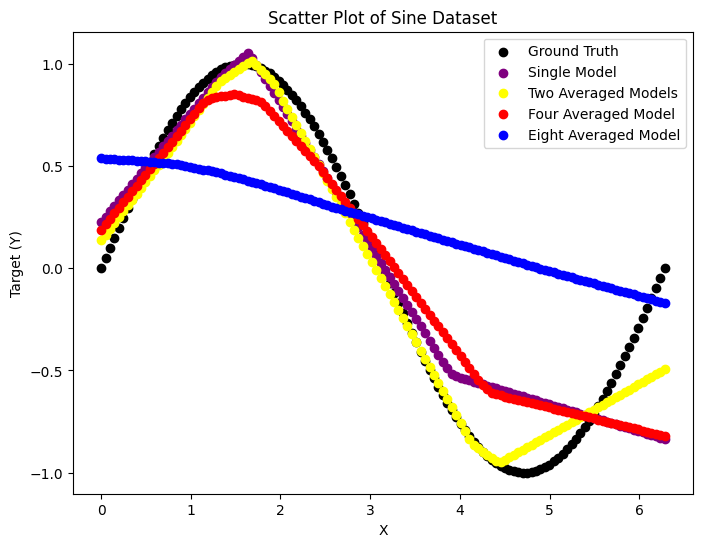

In [31]:
# Extract the data
xs = dataset.xs
ys = dataset.ys

# Plot the data without a colorbar
plt.figure(figsize=(8, 6))
plt.scatter(xs, ys, c="black", label= "Ground Truth")
# for i in range(num_ensembles):
#     plt.scatter(xs, model_outputs[i], label="Model " + str(i))
plt.scatter(xs, model_outputs, c="purple", label="Single Model")
plt.scatter(xs, two_model_averages, c="yellow", label="Two Averaged Models")
plt.scatter(xs, four_model_averages, c="red", label="Four Averaged Model")
plt.scatter(xs, eight_model_averages, c="blue", label="Eight Averaged Model")
plt.title('Scatter Plot of Sine Dataset')
plt.xlabel('X')
plt.ylabel('Target (Y)')
plt.legend()
plt.show()


References:

[1] A.G. Wilson, P. Izmailov. Bayesian Deep Learning and a Probabilistic Perspective of Generalization. Advances in Neural Information Processing Systems, 2020.